In [42]:
import numpy as np
import json
import matplotlib.pyplot as plt
from tools import dirs,tools
import tellurium as te
from data.observations import observations,select_obs
from models.models import Macrophage
from models.params import fixed_params
%load_ext autoreload
%autoreload 2
%matplotlib inline 
plt.rcParams["font.family"] = "serif"
plt.style.use('seaborn-deep')
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
%config Completer.use_jedi = False
showOriginalModelString = True

In [ ]:
##--- import sbml model and edits it to remove invalid ids----#####
if True: # mg model from matlab
    from tools.tools import edit_matlab_model
    edit_matlab_model(input_file=dirs.dir_M1_matlab_model,output_file=dirs.dir_M1_model)
    model = te.loadSBMLModel(dirs.dir_M1_model)
    model_str = model.getAntimony()
    with open('models/M1_sbml_str.txt','w') as file:
        file.write(model_str)
if False: # zhao model
    import sys
    import tellurium as te
    from tools.dirs import dir_Zhao_model
    from tools.tools import edit_matlab_model
    edit_matlab_model(input_file=dir_Zhao_model,output_file=dir_Zhao_model)
    model = te.loadSBMLModel(dir_Zhao_model)
    model_str = model.getAntimony()
    with open('models/%s_str.txt'%'Zhao_sbml','w') as file:
        file.write(model_str)
# run_model(model=model,params = {},duration=200,target_keys=['Mg_f','Mg_e'])

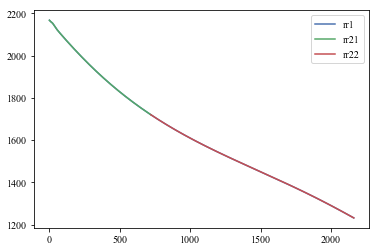

In [3]:
### creating an activated macrophage model ###
zz_model = te.loadSBMLModel(dirs.dir_Zhao_model)
# apply 10ng/ml TNFa for 12h
inputs = {'TNFa':tools.c_2_ac['TNFa']*10} 
species_IDs = zz_model.getFloatingSpeciesIds()
Macrophage.run_sbml_model(model_sbml = zz_model,params = {**inputs},duration = 12*60, selections = ['time']+species_IDs)

# store the stimulated values of the species
activation_stimuli = {}
for ID in species_IDs:
    activation_stimuli[ID] = zz_model[ID]
with open(dirs.dir_activation_stimuli,'w') as ff:
    ff.write(json.dumps(activation_stimuli,indent=4))
    
selection = 'NFKB_n'
def scenario1():
    results = Macrophage.run_sbml_model(model_sbml=zz_model,params={**inputs},duration=36*60,selections = ['time',selection])
    return results
def scenario2():
    rr1 = Macrophage.run_sbml_model(model_sbml=zz_model,params={**inputs},duration=12*60,selections = ['time',selection])
    rr2 = Macrophage.run_sbml_model(model_sbml=zz_model,params={**inputs},duration=24*60,selections = ['time',selection],activation=True)
    return rr1,rr2
rr1 = scenario1()
rr21,rr22 = scenario2()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(rr1['time'],rr1[selection],label='rr1')
ax.plot(rr21['time'],rr21[selection],label='rr21')
ax.plot(rr22['time']+max(rr21['time']),rr22[selection],label='rr22')
ax.legend()


In [ ]:
zz_model = te.loadSBMLModel(dirs.dir_Zhao_model)
# apply TNFa for 12h
species_IDs = zz_model.getFloatingSpeciesIds()
# print(zz_model.get)
tag = 'NFKB_n'
print(tag,zz_model[tag])
results = Macrophage.run_sbml_model(model_sbml = zz_model,duration = 12*60, selections = ['time']+species_IDs)
print(tag,zz_model[tag])

In [16]:
_str = """
    a = 10;
    b = 0;
    at (time ==0), t0=false: b = 1;
"""
mm = te.loada(_str)
results = mm.simulate(0,10,10,selections = ['time','a','b'])
print(results)

       time,  a, b
 [[       0, 10, 1],
  [ 1.11111, 10, 1],
  [ 2.22222, 10, 1],
  [ 3.33333, 10, 1],
  [ 4.44444, 10, 1],
  [ 5.55556, 10, 1],
  [ 6.66667, 10, 1],
  [ 7.77778, 10, 1],
  [ 8.88889, 10, 1],
  [      10, 10, 1]]

